In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import tensorflow.keras.models as tfmodels
import tensorflow.keras.layers as tflayers
import tensorflow.keras.optimizers as tfopt
from tensorflow.keras.utils import plot_model
import math
from scipy.optimize import curve_fit
import scipy.io
from scipy import ndimage

In [2]:
train_data, test_data = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = train_data[0]
x_test = test_data[0]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
train_data_norm = (x_train,train_data[1])
test_data_norm = (x_test,test_data[1])

##Plotting the hand written numbers.

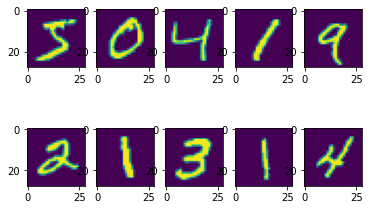

In [4]:
samples = np.arange(0,10,1)
fig,ax = plt.subplots(2,5)
for i in samples:
  im = x_train[i]
  ax[i//5][i%5].imshow(im)

##Defining the CNN model and training it

In [5]:
def define_model():
    IM_SIZE = (28, 28, 1) #last index for validation purposes
    KERNEL_SIZE = (5, 5)
    N_FILTERS = 8
    STRIDE = (2, 2)
    CATEGORIES = 10
    
    # You can pass an array of layers into sequential or
    # just use model.add a bunch of times. Latter is used so that
    # I can comment.
    model = tfmodels.Sequential()
    
    # The basic module of a convolutional network performs a convolution,
    # applies a nonlinearity to each individual unit, and performs pooling.
    # In our case, the convolutional layer has N_FILTERS feature maps with KERNEL_SIZE
    # kernels, the nonlinearity is a ReLU, and we pool by taking the max
    # over a pool of size STRIDE.
    model.add(tflayers.Conv2D(N_FILTERS,
                              KERNEL_SIZE,
                              activation='relu',
                              padding="same",
                              input_shape=IM_SIZE,
                              name='conv2D'#important
                             ))
    model.add(tflayers.MaxPooling2D(STRIDE, name='maxpool'))
    # Incidentally, the "name" parameter just helps us get the layers later
    #model.add(tflayers.Conv2D(N_FILTERS,
    #                          KERNEL_SIZE,
    #                          activation='relu',
    #                          padding="same",
    #                          input_shape=IM_SIZE,
    #                          name='conv2D_1'#important
    #                         ))
    
    #model.add(tflayers.MaxPooling2D(STRIDE, name='maxpool_1'))
    # In Keras, we need to flatten the layer in order to make 
    # the 2D convolution layer work with the 1D dense layer.
    # Note that this discards the 'topographical'
    # arrangement of units in the convolutional layers.
    model.add(tflayers.Flatten(name='flatten'))
    
    # Each unit in a fully connected layer is connected to all units in the
    # preceding layer. Unlike convolutional networks, multi-layer perceptrons 
    # are composed of fully connected layers only.
    # The last fully connected layer has as many neurons/units as there are
    # classes in our classification problem. Note that we don't need ReLU
    # here as we will apply the softmax ("squashing") nonlinearity below.
    model.add(tflayers.Dense(100, activation='relu', name='relu_dense'))
    model.add(tflayers.Dense(CATEGORIES, activation='softmax', name='softmax'))
    # The training parameters in tensorflow are packaged with the model
    # instead of being held separately. SGD here means stochastic gradient
    # descent.
    opt = tfopt.SGD(learning_rate=0.01,
                    momentum=0.9
                   )
    # compile!
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
                 )
    return model

In [6]:
def train_model(model, train_data, test_data):
    result = model.fit(*train_data,
                        epochs = 5, #there are more efficient ways than just training longer
                        batch_size = 128,
                        shuffle = True,
                        validation_data = test_data
                       )
    return result

In [7]:
mod = define_model()
mod.summary()
result = train_model(mod,train_data_norm,test_data_norm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 28, 28, 8)         208       
                                                                 
 maxpool (MaxPooling2D)      (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 relu_dense (Dense)          (None, 100)               156900    
                                                                 
 softmax (Dense)             (None, 10)                1010      
                                                                 
Total params: 158,118
Trainable params: 158,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


469/469 [==============================] - 33s 67ms/step - loss: 0.3059 - accuracy: 0.9127 - val_loss: 0.1273 - val_accuracy: 0.9607
Epoch 2/5
469/469 [==============================] - 24s 51ms/step - loss: 0.0991 - accuracy: 0.9702 - val_loss: 0.0822 - val_accuracy: 0.9748
Epoch 3/5
469/469 [==============================] - 24s 52ms/step - loss: 0.0687 - accuracy: 0.9795 - val_loss: 0.0571 - val_accuracy: 0.9813
Epoch 4/5
469/469 [==============================] - 24s 52ms/step - loss: 0.0546 - accuracy: 0.9837 - val_loss: 0.0538 - val_accuracy: 0.9815
Epoch 5/5
469/469 [==============================] - 24s 51ms/step - loss: 0.0437 - accuracy: 0.9866 - val_loss: 0.0474 - val_accuracy: 0.9843


#### The Architeture of the model

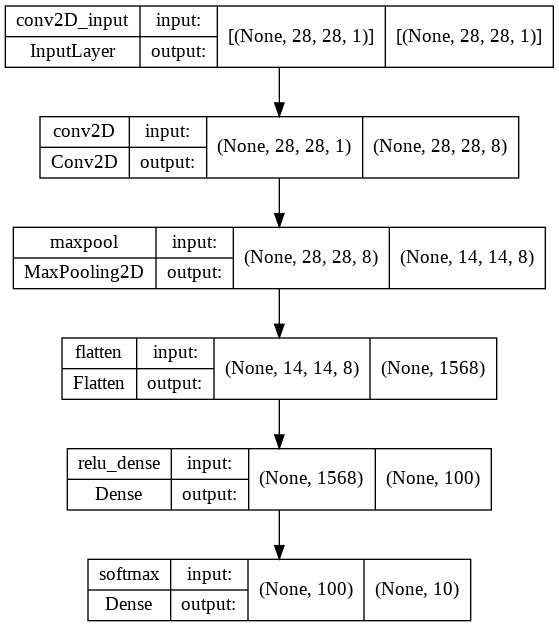

In [8]:
plot_model(mod, 'model.png', show_shapes=True)

## Plotting the filters obtained from the CNN layer

In [9]:
conv_weights = np.array(result.model.get_layer("conv2D").weights[0])
# f_min, f_max = conv_weights.min(), conv_weights.max()
# conv_weights = (conv_weights - f_min) / (f_max - f_min)

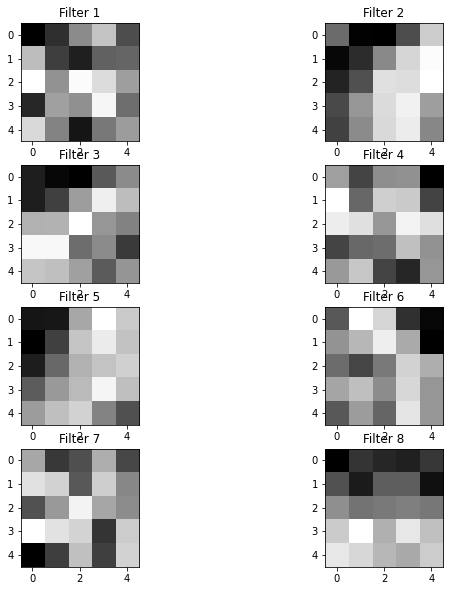

In [10]:
fig, axs = plt.subplots(4,2,figsize = (10,10))
for i in range(8):
  filter = conv_weights[:,:,:,i][:,:,0]
  axs[i//2][i%2].imshow(filter,cmap ='gray')
  axs[i//2][i%2].set_title('Filter ' +str(i+1))

These filters are somewhat reminicent of the Gabors functions we saw in HW-4. There seems to be some periodicity which could modelled by the planar wave of the gabor function. Also there is a good distribution of values which could be modelled by the gaussian part of the gabor filter.

## Fitting these filters to the Gabor function

In [11]:
def gabor_func(data,k,phi,theta):
  x,y = data
  ans = (1/(2*np.pi*5*5)) * np.exp( ( - ( (x**2)/( 2*( 5**2 ) ) ) - ( (y**2)/( 2*( 5**2 ) ) ) )) * np.cos(k*x*np.cos(theta)+k*y*np.sin(theta)-phi)
  return ans

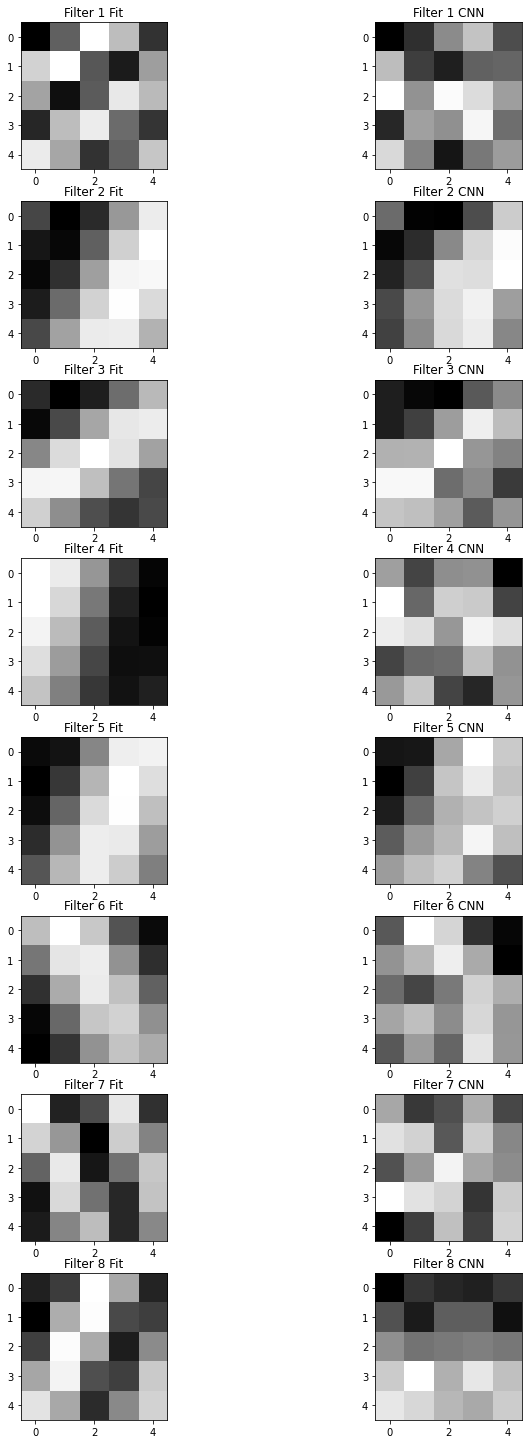

In [12]:
fig,axs = plt.subplots(8,2,figsize=(10,20))
fig.tight_layout()
for k in range(8):
  x_data = np.arange(0,5,1)
  y_data = np.arange(0,5,1)
  x_data = np.tile(x_data,5)
  y_data = np.repeat(y_data,5)
  z_data = conv_weights[:,:,:,k].flatten()
  dat = (x_data,y_data)
  params, cov = curve_fit(gabor_func,dat,z_data,maxfev = 12000)
  res = np.zeros([5,5])
  for i in range(5):
    for j in range(5):
      dat = (j,i)
      res[i][j] = gabor_func(dat,params[0],params[1],params[2])
  axs[k][0].set_title('Filter ' + str(k+1) + ' Fit')
  axs[k][0].imshow(res,cmap = 'gray')
  filter = conv_weights[:,:,:,k][:,:,0]
  axs[k][1].set_title('Filter ' + str(k+1) + ' CNN')
  axs[k][1].imshow(filter,cmap ='gray')
  # plt.title('Filter ' + str(k+1))
  # plt.plot(res,label = 'fit')
  # plt.plot(z_data,label='data')
  # plt.legend()

## Convolving given Filters with the digits

In [13]:
filters = scipy.io.loadmat('Q7Filters.mat')

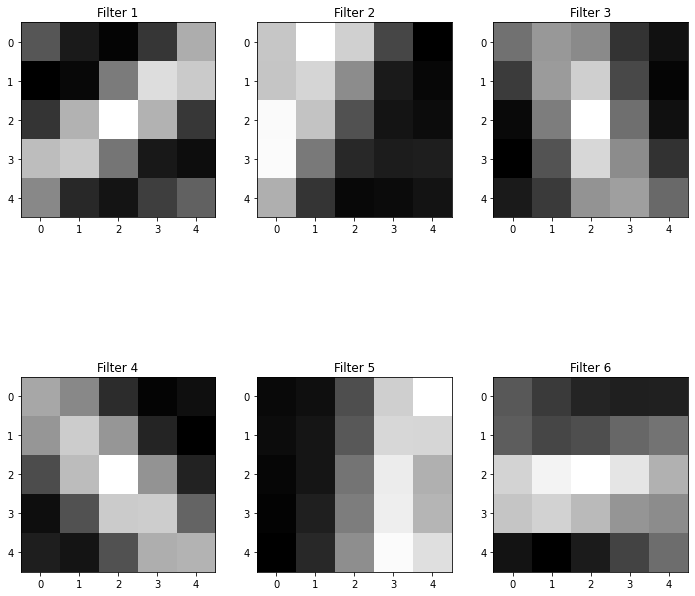

In [14]:
fig,axs = plt.subplots(2,3,figsize=(10,10))
fig.tight_layout()
for i in range(6):
  filter = filters['finalFilters'][:,:,i]
  axs[i//3][i%3].set_title('Filter ' + str(i+1))
  axs[i//3][i%3].imshow(filter,cmap='gray')

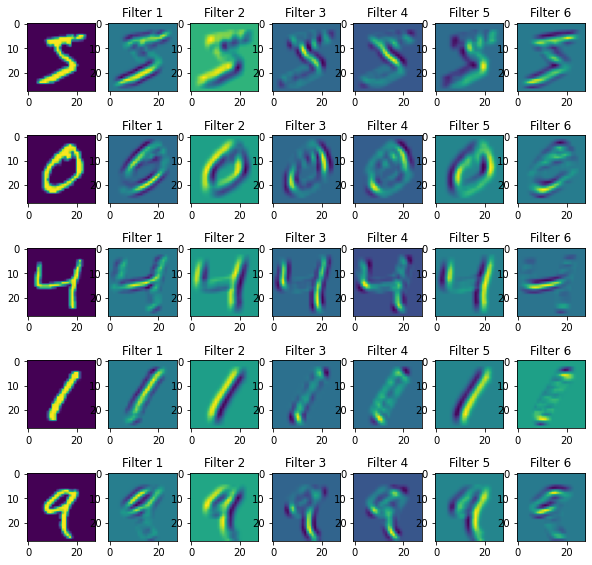

In [15]:
figs, ax = plt.subplots(5,7,figsize=(10,10))
for i in range(5):
  im = x_train[i]
  for j in range(7):
      if j ==0:
        ax[i][j].imshow(im)
      else:
        filter = filters['finalFilters'][:,:,j-1]
        res = ndimage.convolve(im,filter)
        ax[i][j].imshow(res)
        ax[i][j].set_title("Filter " +str(j))

Based on these images, I believe that these filters select the following features \
Filter 1 - Features along the diagnol from the bottom left to top right.\
Filter 2 - It seems like this filter identifies the edges of the numbers and distinguishes the background from the number.\
Filter 3 - This could be a filter that identifies the start and endpoints of the numbers when written. This is why the bottom of the number 1, left stalk and end of right stalk on 4 seem to be highlighted\
Filter 4 - Features along the diagnol from the bottom right to top left. Seems like a mirror image of the filter 1.\
Filter 5 - Vertical feaetures. This could identifying the vertical line present in number like 1, 4, 7, etc\
Filter 6 - Horizontal features in the image

## Perceptron Model for classifying the images

In [16]:
def define_model_perc():
    IM_SIZE = (28, 28, 1) #last index for validation purposes
    CATEGORIES = 10
    
    model = tfmodels.Sequential()
    model.add(tflayers.Flatten(input_shape=IM_SIZE, name='flatten'))
    model.add(tflayers.Dense(10, activation='relu', name='relu_dense_1'))
    model.add(tflayers.Dense(500, activation='relu', name='relu_dense_2'))
    model.add(tflayers.Dense(500, activation='relu', name='relu_dense_3'))
    model.add(tflayers.Dense(CATEGORIES, activation='softmax', name='softmax'))

    opt = tfopt.SGD(learning_rate=0.01,
                    momentum=0.9
                   )
    # compile!
    model.compile(optimizer='adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
                 )
    return model

In [17]:
mod_per = define_model_perc()
mod_per.summary()
result_per = train_model(mod_per,train_data_norm,test_data_norm)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 relu_dense_1 (Dense)        (None, 10)                7850      
                                                                 
 relu_dense_2 (Dense)        (None, 500)               5500      
                                                                 
 relu_dense_3 (Dense)        (None, 500)               250500    
                                                                 
 softmax (Dense)             (None, 10)                5010      
                                                                 
Total params: 268,860
Trainable params: 268,860
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


469/469 [==============================] - 5s 10ms/step - loss: 0.4166 - accuracy: 0.8716 - val_loss: 0.2347 - val_accuracy: 0.9261
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.2040 - accuracy: 0.9380 - val_loss: 0.1853 - val_accuracy: 0.9447
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1610 - accuracy: 0.9498 - val_loss: 0.1643 - val_accuracy: 0.9496
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1432 - accuracy: 0.9553 - val_loss: 0.1432 - val_accuracy: 0.9574
Epoch 5/5
469/469 [==============================] - 4s 10ms/step - loss: 0.1300 - accuracy: 0.9591 - val_loss: 0.1440 - val_accuracy: 0.9557


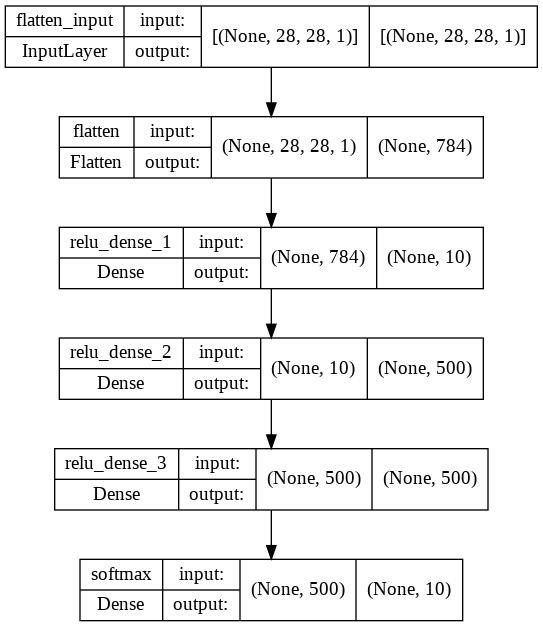

In [18]:
plot_model(mod_per, 'model.png', show_shapes=True)

In [19]:
conv_weights_2 = np.array(result_per.model.get_layer("relu_dense_1").weights[0])

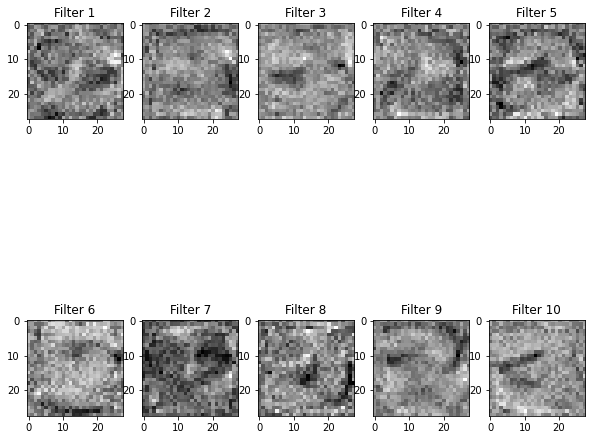

In [20]:
fig, axs = plt.subplots(2,5,figsize = (10,10))
for i in range(10):
  filter_per = conv_weights_2[:,i].reshape(28,28)
  axs[i//5][i%5].imshow(filter_per,cmap = "gray")
  axs[i//5][i%5].set_title("Filter " + str(i+1))


One of the first differences that we will notice is that these are 28x28 filters and not like the 5x5 filters we saw in the CNN. This is expected as we don't have any convolution in this network and the network must filter features in the image at once.\
Compared to the CNN case where each filter seemed to extract a feature like left daignol, right diagnol etc, it seems that the weights in these neurons are designed to take data from certain regions. For example, in filter 2, the data with heigher wieghts are in the shape of a 0. Thus it is selected regions not in the center and not in the extremities.